Одобеску Роман, public_kaggle_score = 0.99893  
В данном ноутбуке применил стекинг с голосованием большинством

In [1]:
import numpy as np
import pandas as pd
import torch

import PIL
print(PIL.__version__)

#file paths
#/kaggle/input/journeyspringfield/train')
#/kaggle/input/journeyspringfield/testset/testset

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

8.0.1
CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=10
BATCH_SIZE=32

### Augmentations

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensor

augmentations_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)

### Class SimponsDataset

In [25]:
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    
  
    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [19]:
TRAIN_DIR = Path('/kaggle/input/journeyspringfield/train')
TEST_DIR = Path('/kaggle/input/journeyspringfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [20]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
# train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
#                                           stratify=train_val_labels)
train_files = train_val_files.copy()

In [28]:
# val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train', augmentations = augmentations_pipeline)

In [29]:
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

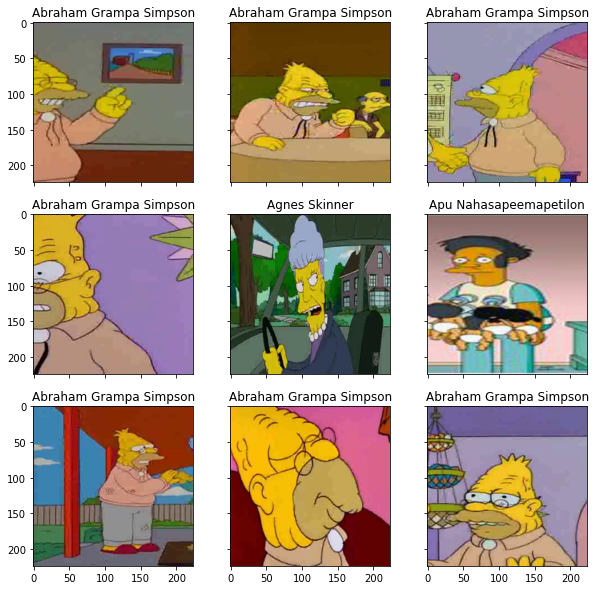

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [31]:
class ConvModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=164, kernel_size=3),
            nn.BatchNorm2d(164),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 164, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU()
        )        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 164)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        logits = self.out(x)
        return logits

In [38]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Здесь можно добавить схему изменения learning rate
        
        opt = torch.optim.AdamW(model.parameters(), lr = 3e-4)
        
        # добавлен scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=1, verbose=False)
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            scheduler.step(val_acc)
            
    return history

In [39]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [40]:
n_classes = len(np.unique(train_val_labels))
model = ConvModel(n_classes).to(DEVICE)
print(model)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Train


In [41]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [42]:
submit = pd.DataFrame(columns=['Id'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 1
loss 1.7481408244917416


epoch:  10%|█         | 1/10 [03:53<34:58, 233.22s/it]


Epoch 001 train_loss: 1.7481     val_loss 1.3002 train_acc 0.5275 val_acc 0.6413
loss 0.9835478856289357


epoch:  20%|██        | 2/10 [07:29<30:25, 228.18s/it]


Epoch 002 train_loss: 0.9835     val_loss 0.8417 train_acc 0.7249 val_acc 0.7690
loss 0.5841413554888422


epoch:  30%|███       | 3/10 [10:52<25:43, 220.54s/it]


Epoch 003 train_loss: 0.5841     val_loss 0.6826 train_acc 0.8325 val_acc 0.8151
loss 0.3606036490486341


epoch:  40%|████      | 4/10 [14:20<21:41, 216.93s/it]


Epoch 004 train_loss: 0.3606     val_loss 0.6283 train_acc 0.8942 val_acc 0.8469
loss 0.2094482328481576


epoch:  50%|█████     | 5/10 [17:56<18:02, 216.57s/it]


Epoch 005 train_loss: 0.2094     val_loss 0.6488 train_acc 0.9366 val_acc 0.8354
loss 0.14657517279760002


epoch:  60%|██████    | 6/10 [21:19<14:10, 212.57s/it]


Epoch 006 train_loss: 0.1466     val_loss 0.7885 train_acc 0.9546 val_acc 0.8252
loss 0.03825259500703273


epoch:  70%|███████   | 7/10 [24:49<10:34, 211.59s/it]


Epoch 007 train_loss: 0.0383     val_loss 0.5933 train_acc 0.9898 val_acc 0.8746
loss 0.0090327057217467


epoch:  80%|████████  | 8/10 [28:09<06:56, 208.31s/it]


Epoch 008 train_loss: 0.0090     val_loss 0.6211 train_acc 0.9990 val_acc 0.8794
loss 0.00469397610527427


epoch:  90%|█████████ | 9/10 [31:53<03:32, 212.91s/it]


Epoch 009 train_loss: 0.0047     val_loss 0.6540 train_acc 0.9995 val_acc 0.8796
loss 0.0028013556208754055


epoch: 100%|██████████| 10/10 [35:21<00:00, 212.12s/it]


Epoch 010 train_loss: 0.0028     val_loss 0.6842 train_acc 0.9997 val_acc 0.8815


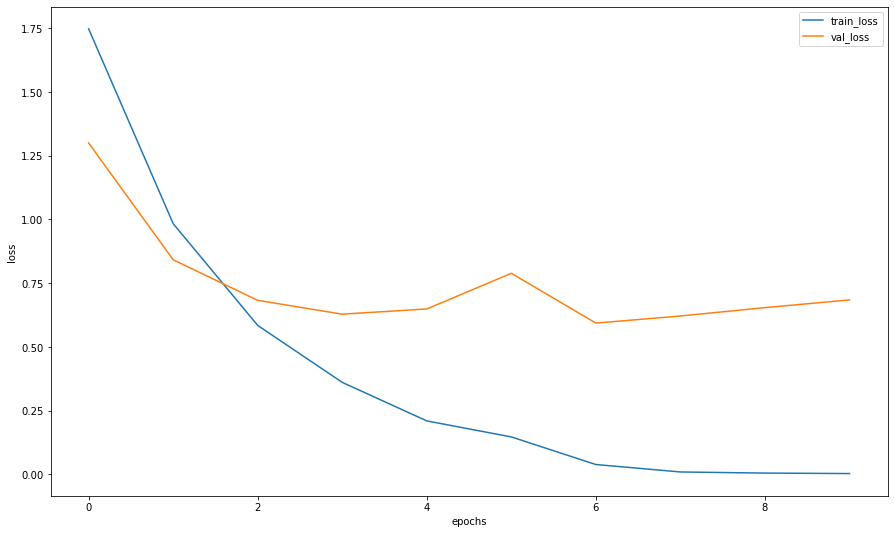

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 2
loss 1.7701879326949534


epoch:  10%|█         | 1/10 [04:04<36:38, 244.24s/it]


Epoch 001 train_loss: 1.7702     val_loss 1.3116 train_acc 0.5205 val_acc 0.6460
loss 0.9778781656323119


epoch:  20%|██        | 2/10 [07:43<31:35, 236.88s/it]


Epoch 002 train_loss: 0.9779     val_loss 0.8952 train_acc 0.7298 val_acc 0.7519
loss 0.5817466729162529


epoch:  30%|███       | 3/10 [11:05<26:24, 226.33s/it]


Epoch 003 train_loss: 0.5817     val_loss 0.7625 train_acc 0.8343 val_acc 0.8013
loss 0.35140233409564214


epoch:  40%|████      | 4/10 [14:45<22:26, 224.38s/it]


Epoch 004 train_loss: 0.3514     val_loss 0.6745 train_acc 0.8984 val_acc 0.8299
loss 0.20357451152931164


epoch:  50%|█████     | 5/10 [18:57<19:22, 232.59s/it]


Epoch 005 train_loss: 0.2036     val_loss 0.6852 train_acc 0.9390 val_acc 0.8452
loss 0.13155230940470314


epoch:  60%|██████    | 6/10 [22:30<15:07, 226.77s/it]


Epoch 006 train_loss: 0.1316     val_loss 0.8210 train_acc 0.9601 val_acc 0.8369
loss 0.1047792507146009


epoch:  70%|███████   | 7/10 [26:27<11:30, 230.00s/it]


Epoch 007 train_loss: 0.1048     val_loss 0.8639 train_acc 0.9692 val_acc 0.8266
loss 0.02024750324073148


epoch:  80%|████████  | 8/10 [29:56<07:26, 223.46s/it]


Epoch 008 train_loss: 0.0202     val_loss 0.6579 train_acc 0.9950 val_acc 0.8717
loss 0.004236368892010745


epoch:  90%|█████████ | 9/10 [33:28<03:40, 220.07s/it]


Epoch 009 train_loss: 0.0042     val_loss 0.6900 train_acc 0.9998 val_acc 0.8720
loss 0.002448627393004817


epoch: 100%|██████████| 10/10 [37:11<00:00, 223.12s/it]


Epoch 010 train_loss: 0.0024     val_loss 0.7122 train_acc 0.9998 val_acc 0.8725


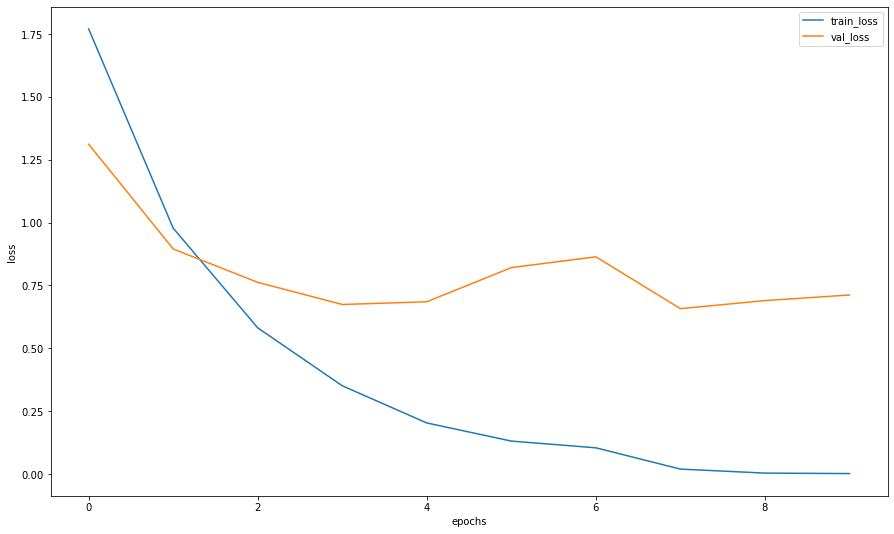

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 3
loss 1.7865788074970872


epoch:  10%|█         | 1/10 [03:27<31:04, 207.17s/it]


Epoch 001 train_loss: 1.7866     val_loss 5.3835 train_acc 0.5137 val_acc 0.3587
loss 1.0020314125580185


epoch:  20%|██        | 2/10 [06:57<27:45, 208.20s/it]


Epoch 002 train_loss: 1.0020     val_loss 6.4332 train_acc 0.7180 val_acc 0.3986
loss 0.6207633163856945


epoch:  30%|███       | 3/10 [10:23<24:12, 207.44s/it]


Epoch 003 train_loss: 0.6208     val_loss 8.1577 train_acc 0.8250 val_acc 0.4041
loss 0.3653143475940688


epoch:  40%|████      | 4/10 [13:43<20:31, 205.25s/it]


Epoch 004 train_loss: 0.3653     val_loss 8.3659 train_acc 0.8951 val_acc 0.4285
loss 0.2210915542006222


epoch:  50%|█████     | 5/10 [17:15<17:16, 207.36s/it]


Epoch 005 train_loss: 0.2211     val_loss 10.2260 train_acc 0.9310 val_acc 0.4089
loss 0.15113618761651634


epoch:  60%|██████    | 6/10 [20:43<13:49, 207.42s/it]


Epoch 006 train_loss: 0.1511     val_loss 10.9559 train_acc 0.9537 val_acc 0.4438
loss 0.10272932335268094


epoch:  70%|███████   | 7/10 [23:58<10:11, 203.74s/it]


Epoch 007 train_loss: 0.1027     val_loss 12.5941 train_acc 0.9688 val_acc 0.4323
loss 0.0753675185646815


epoch:  80%|████████  | 8/10 [27:16<06:44, 202.07s/it]


Epoch 008 train_loss: 0.0754     val_loss 13.6333 train_acc 0.9775 val_acc 0.4211
loss 0.01742532519614405


epoch:  90%|█████████ | 9/10 [30:45<03:24, 204.09s/it]


Epoch 009 train_loss: 0.0174     val_loss 13.7815 train_acc 0.9955 val_acc 0.4471
loss 0.0032226468177574707


epoch: 100%|██████████| 10/10 [34:01<00:00, 204.11s/it]


Epoch 010 train_loss: 0.0032     val_loss 14.5733 train_acc 0.9996 val_acc 0.4490


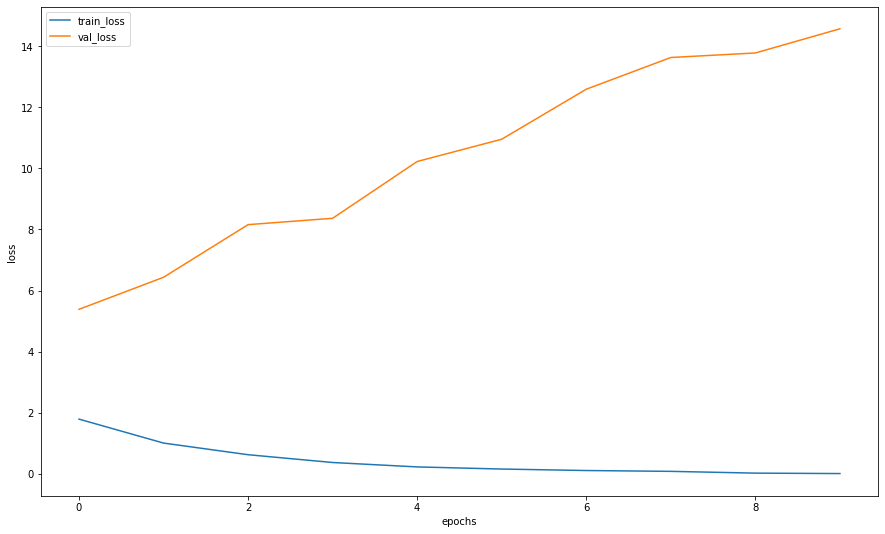

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 4
loss 1.762882324341924


epoch:  10%|█         | 1/10 [03:16<29:31, 196.86s/it]


Epoch 001 train_loss: 1.7629     val_loss 4.8432 train_acc 0.5206 val_acc 0.3493
loss 0.9741490315987387


epoch:  20%|██        | 2/10 [06:32<26:12, 196.59s/it]


Epoch 002 train_loss: 0.9741     val_loss 6.2434 train_acc 0.7299 val_acc 0.3626
loss 0.5821893998578164


epoch:  30%|███       | 3/10 [09:59<23:17, 199.70s/it]


Epoch 003 train_loss: 0.5822     val_loss 7.6025 train_acc 0.8336 val_acc 0.4114
loss 0.3328131648749175


epoch:  40%|████      | 4/10 [13:53<20:58, 209.83s/it]


Epoch 004 train_loss: 0.3328     val_loss 8.7758 train_acc 0.9014 val_acc 0.4152
loss 0.198857665812036


epoch:  50%|█████     | 5/10 [17:48<18:07, 217.50s/it]


Epoch 005 train_loss: 0.1989     val_loss 9.8739 train_acc 0.9398 val_acc 0.4154
loss 0.1545310180803096


epoch:  60%|██████    | 6/10 [21:14<14:15, 214.00s/it]


Epoch 006 train_loss: 0.1545     val_loss 9.8494 train_acc 0.9529 val_acc 0.4305
loss 0.10110265972668492


epoch:  70%|███████   | 7/10 [24:30<10:25, 208.48s/it]


Epoch 007 train_loss: 0.1011     val_loss 12.3942 train_acc 0.9692 val_acc 0.4262
loss 0.07316199750519656


epoch:  80%|████████  | 8/10 [27:51<06:52, 206.32s/it]


Epoch 008 train_loss: 0.0732     val_loss 12.7819 train_acc 0.9778 val_acc 0.4341
loss 0.06656684862785373


epoch:  90%|█████████ | 9/10 [31:18<03:26, 206.58s/it]


Epoch 009 train_loss: 0.0666     val_loss 13.4014 train_acc 0.9796 val_acc 0.4329
loss 0.0622060885813825


epoch: 100%|██████████| 10/10 [34:49<00:00, 208.94s/it]


Epoch 010 train_loss: 0.0622     val_loss 14.1817 train_acc 0.9820 val_acc 0.4288


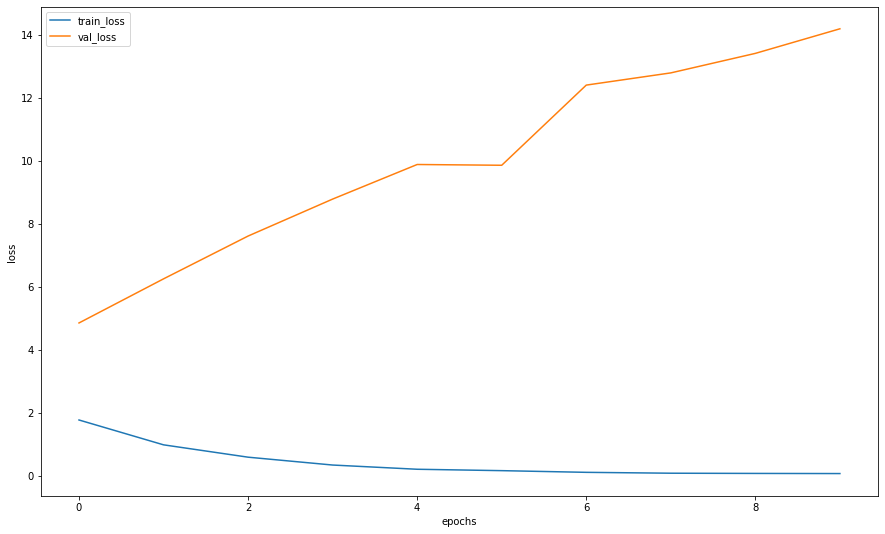

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


FOLD 5
loss 1.7092461681311868


epoch:  10%|█         | 1/10 [03:27<31:07, 207.47s/it]


Epoch 001 train_loss: 1.7092     val_loss 1.0849 train_acc 0.5364 val_acc 0.7105
loss 0.956037187625054


epoch:  20%|██        | 2/10 [06:57<27:46, 208.31s/it]


Epoch 002 train_loss: 0.9560     val_loss 0.8355 train_acc 0.7334 val_acc 0.7673
loss 0.5689177225260633


epoch:  30%|███       | 3/10 [10:25<24:17, 208.15s/it]


Epoch 003 train_loss: 0.5689     val_loss 0.6642 train_acc 0.8377 val_acc 0.8213
loss 0.336844597219346


epoch:  40%|████      | 4/10 [14:10<21:18, 213.16s/it]


Epoch 004 train_loss: 0.3368     val_loss 0.6978 train_acc 0.9005 val_acc 0.8218
loss 0.19519536737607865


epoch:  50%|█████     | 5/10 [17:50<17:56, 215.34s/it]


Epoch 005 train_loss: 0.1952     val_loss 0.7757 train_acc 0.9418 val_acc 0.8256
loss 0.14316882836756054


epoch:  60%|██████    | 6/10 [21:44<14:43, 220.93s/it]


Epoch 006 train_loss: 0.1432     val_loss 0.9390 train_acc 0.9558 val_acc 0.7931
loss 0.1031044599892485


epoch:  70%|███████   | 7/10 [25:22<10:59, 219.94s/it]


Epoch 007 train_loss: 0.1031     val_loss 0.7408 train_acc 0.9706 val_acc 0.8430
loss 0.07584295198006026


epoch:  80%|████████  | 8/10 [29:14<07:27, 223.53s/it]


Epoch 008 train_loss: 0.0758     val_loss 0.8742 train_acc 0.9772 val_acc 0.8278
loss 0.06516470264176519


epoch:  90%|█████████ | 9/10 [32:55<03:42, 222.79s/it]


Epoch 009 train_loss: 0.0652     val_loss 0.8234 train_acc 0.9809 val_acc 0.8423
loss 0.014165826260741662


epoch: 100%|██████████| 10/10 [36:37<00:00, 219.76s/it]



Epoch 010 train_loss: 0.0142     val_loss 0.6794 train_acc 0.9964 val_acc 0.8724


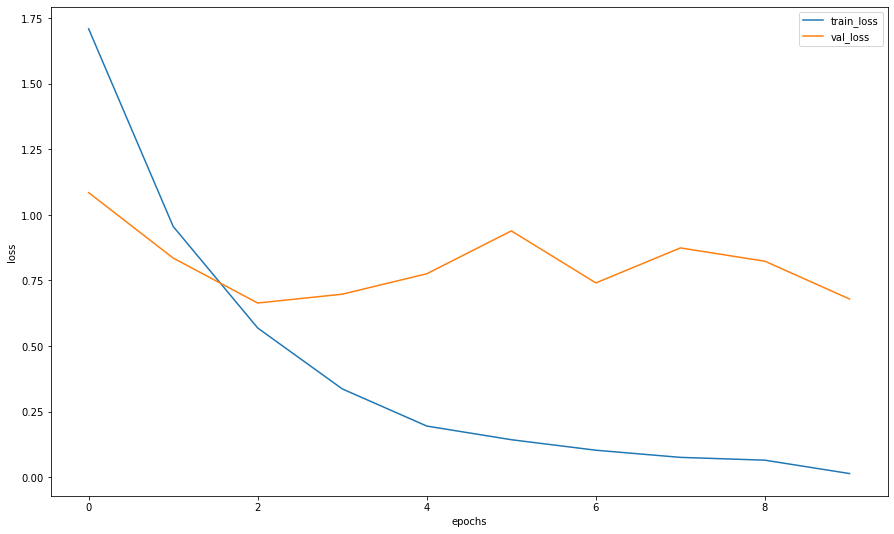

In [43]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    model = ConvModel(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds

# Submission

In [44]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit.head(50)

,Id,fold_1,fold_2,fold_3,fold_4,fold_5
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman
6,img103.jpg,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel
7,img104.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
8,img105.jpg,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson
9,img106.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman


In [45]:
submit['Expected'] = submit.mode(axis=1)[0]

In [46]:
submit.head()

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,Expected
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon


In [49]:
submit[['Id', 'Expected']].to_csv('/kaggle/working/submission.csv', index=False)